## Task 0.

We have data corpus of text in 4 categories. Our task is to classify them into those categories.

In [ ]:
import pandas as pd
df_train = pd.read_csv('/content/train.csv', error_bad_lines=False)
df_train = df_train.dropna()
df_train.head()

,text,source
0,Российская сборная лидирует по итогам командно...,mchsgov
1,#СоветМЧС #МЧС #МЧСРОССИИ,mchsgov
2,Инспекторы ГИБДД Москвы приняли участие во Все...,mospolice
3,В Главную Военно-Морскую Базу БФ в г.Балтийск ...,mil
4,Обвиняемые в хищении денежных средств у 32 пож...,mospolice


In [ ]:
df_train.shape

(9794, 2)

## 1. Data preprocessing


* Bring all texts to the same length, replace words / tokens with numbers, factorize the target variable

* Split everything into tokens using (https://github.com/huggingface/tokenizers)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
SEQLEN = 250

In [ ]:
!pip install tokenizers

     |████████████████████████████████| 3.2MB 7.2MB/s 


In [ ]:
lines = [str(line) for line in df_train["text"].to_numpy()]

max length: 13306


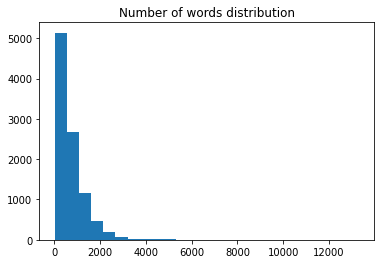

In [ ]:
MAX_LENGTH = max(map(len, lines))
print("max length:", MAX_LENGTH)

plt.title('Number of words distribution')
plt.hist(list(map(len, lines)), bins=25);

In [ ]:
from tokenizers.pre_tokenizers import Whitespace, Digits
from tokenizers import pre_tokenizers 
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
import tokenizers
import numpy as np

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits(individual_digits=False)])
trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.enable_padding(pad_id=0, pad_token="[PAD]", length=SEQLEN)

tokenizer.train_from_iterator(lines, trainer=trainer)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
words_to_remove = stopwords.words("russian")
tokenizer.add_special_tokens(tokens = words_to_remove)

In [ ]:
#ids_to_remove = [tokenizer.encode(word).ids[0] for word in words_to_remove]

Let's use OHE for our target (it will be done a bit later)

In [ ]:
target = list(set(df_train['source'].values))
target

['mospolice', 'mil', 'mchsgov', 'russianpost']

Now to the data itself

In [ ]:
train_text_x = []

for line in df_train['text']:
  train_text_x.append(list(tokenizer.encode(line).ids)[:SEQLEN])
df_train['tokens'] = train_text_x

In [ ]:
MAX_LENGTH = max(map(len, df_train['tokens']))
print("max length:", MAX_LENGTH)
MIN_LENGTH = min(map(len, df_train['tokens']))
print("min length:", MIN_LENGTH)

max length: 250
min length: 250


Same with our test data

In [ ]:
df_test = pd.read_csv('/content/test.csv')
df_test.head()

,text
0,На полигоне «Погоново» Воронежской области про...
1,#БудниМЧС #МЧС #МЧСРОССИИ <br><br>Пожарные тра...
2,"Друзья, напоминаем вам, что завтра единый день..."
3,"Настольная игра: ""Королевская почта""<br><br>По..."
4,Миллиарды писем разносят по почтовым ящикам на...


In [ ]:
test_text_x = []

for line in df_test['text']:
  if line != line:
    line = ''
  test_text_x.append(list(tokenizer.encode(line).ids)[:SEQLEN])
df_test['tokens'] = test_text_x

## 2. LSTM-net

Build LSTM from scratch use this [architechture](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [ ]:
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
in_tok, out_tok = 30000, len(target)
out_dim=64

In [ ]:
from keras import backend
from keras.engine.topology import Layer

import tensorflow as tf

class my_lstm(Layer):
    def __init__(self, units=32, **kwargs):
      self.units = units
      self.state_size = [units, units]
      self.built = False
      super(my_lstm, self).__init__(**kwargs)
      
    def build(self, in_sh):
      self.b = [self.add_weight(name='bf', shape=(1, self.units), initializer='zeros'),
                self.add_weight(name='bi', shape=(1, self.units), initializer='zeros'),
                self.add_weight(name='bc', shape=(1, self.units), initializer='zeros'),
                self.add_weight(name='b0', shape=(1, self.units), initializer='zeros')]
      
      self.xt = [self.add_weight(name='xft', shape=(in_sh[-1], self.units), initializer='uniform'),
                self.add_weight(name='xit', shape=(in_sh[-1], self.units), initializer='uniform'),
                self.add_weight(name='xct', shape=(in_sh[-1], self.units), initializer='uniform'),
                self.add_weight(name='x0t', shape=(in_sh[-1], self.units), initializer='uniform')]

      self.ht = [self.add_weight(name='hft', shape=(self.units, self.units), initializer='uniform'),
                self.add_weight(name='hit', shape=(self.units, self.units), initializer='uniform'),
                self.add_weight(name='hct', shape=(self.units, self.units), initializer='uniform'),
                self.add_weight(name='h0t', shape=(self.units, self.units), initializer='uniform')]
      self.built = True

    def call(self, x, hc, mask):
      h, c = hc

      c_new = (backend.sigmoid(backend.dot(h, self.ht[0]) + self.b[0] + backend.dot(x, self.xt[0])) * c +
        backend.sigmoid(backend.dot(h, self.ht[1]) + self.b[1] + backend.dot(x, self.xt[1])) *
        backend.tanh(backend.dot(h, self.ht[2]) + self.b[2] + backend.dot(x, self.xt[2])))
      
      h_new = (backend.sigmoid(backend.dot(h, self.ht[3]) + self.b[3] + backend.dot(x, self.xt[3])) *
              backend.tanh(c_new))
      if mask != None:
        h_new = tf.where(mask, h_new, h)
        c_new = tf.where(mask, c_new, c)
      
      return h_new, c_new


In [ ]:
from keras.layers import Embedding
#from tensorflow.python.keras.engine.base_layer import Layer
from keras.utils.generic_utils import to_list
from keras.utils.generic_utils import unpack_singleton

class rnn(Layer):
  def __init__(self,
               cell,
               **kwargs):
    self.cell = cell
    #self.embedding = layers.Embedding(in_tok, out_dim, mask_zero=True)
    super(rnn, self).__init__(**kwargs)

  def build(self, input_shape):
    if not self.cell.built:
      self.cell.build(input_shape)
      self.cell.built = True
    self.built = True
  
  def call(self, inputs, mask=None, **kwargs):
    hc = [tf.zeros(shape=(tf.shape(inputs)[0], self.cell.units)),
          tf.zeros(shape=(tf.shape(inputs)[0], self.cell.units))]
    
    for i in range(SEQLEN):
      hc[0], hc[1] = self.cell.call(inputs[:,i,:], hc, tf.reshape(mask[:, i], [tf.shape(inputs)[0], 1]))
    return hc[0]

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'return_sequences': self.return_sequences 
    })
    return config

## 3. Model

Use your cell with some others for the final model.

In [ ]:
from keras.layers import RNN, Dense, Activation,LSTM, Embedding, TimeDistributed
from keras.models import Model
import keras

In [ ]:
batch_size = 128
epochs = 7

In [ ]:
model = Sequential()
model.add(Embedding(in_tok, out_dim, input_length=SEQLEN, mask_zero=True))
model.add(rnn(my_lstm(units = SEQLEN)))
model.add((Dense(out_tok)))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           1920000   
_________________________________________________________________
rnn (rnn)                    (None, 250)               315000    
_________________________________________________________________
dense (Dense)                (None, 4)                 1004      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 2,236,004
Trainable params: 2,236,004
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
[print(i.shape, i.dtype) for i in model.inputs]
print('-------')
[print(o.shape, o.dtype) for o in model.outputs]
print('-------')
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 250) <dtype: 'float32'>
-------
(None, 4) <dtype: 'float32'>
-------
embedding (None, 250) float32
rnn (None, 250, 64) float32
dense (None, 250) float32
activation (None, 4) float32


[None, None, None, None]

Prepare batch and encode our target

In [ ]:
id_to_source = {0: 'mchsgov', 1: 'mil', 2: 'mospolice', 3: 'russianpost'}

In [ ]:
df_train_target = pd.get_dummies(df_train['source'])
print(df_train_target.head())

   mchsgov  mil  mospolice  russianpost
0        1    0          0            0
1        1    0          0            0
2        0    0          1            0
3        0    1          0            0
4        0    0          1            0


untoked_data - used for a model with tfidf

In [ ]:
train_x, test_x, untoked_train, untoked_test, train_y, test_y = train_test_split(train_text_x, df_train_target, test_size=0.2, random_state=42)

In [ ]:
class batch_gen(object):
    def __init__(self, feat, target, batch_size):
      self.feat = feat
      self.target = target
      self.id = 0
      self.batch_size = batch_size
    def generate(self):
      x = np.zeros((self.batch_size, SEQLEN))
      y = np.zeros((self.batch_size, SEQLEN, self.target.shape[1]))
      while 1:
        if self.id + self.batch_size > len(self.feat):
          self.id = 0
        x = np.asarray(self.feat[self.id : self.id + batch_size])
        x = np.asarray([np.asarray(line) for line in x])

        y = np.asarray(np.asarray(self.target[self.id : self.id + batch_size]))
        self.id += 7
        yield x, y

train_data_generator = batch_gen(train_x, train_y, batch_size)
valid_data_generator = batch_gen(test_x, test_y, batch_size)

In [ ]:
model.fit_generator(train_data_generator.generate(), len(train_x)//(batch_size), epochs=17,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(test_x)//(batch_size))#, callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/17
61/61 [==============================] - 128s 436ms/step - loss: 1.2789 - categorical_accuracy: 0.4541 - val_loss: 0.9496 - val_categorical_accuracy: 0.5813
Epoch 2/17
61/61 [==============================] - 13s 209ms/step - loss: 0.4829 - categorical_accuracy: 0.8634 - val_loss: 1.2725 - val_categorical_accuracy: 0.5927
Epoch 3/17
61/61 [==============================] - 13s 211ms/step - loss: 0.3050 - categorical_accuracy: 0.9086 - val_loss: 1.0345 - val_categorical_accuracy: 0.7021
Epoch 4/17
61/61 [==============================] - 13s 217ms/step - loss: 0.2432 - categorical_accuracy: 0.9250 - val_loss: 0.7270 - val_categorical_accuracy: 0.7635
Epoch 5/17
61/61 [==============================] - 13s 212ms/step - loss: 0.1648 - categorical_accuracy: 0.9504 - val_loss: 0.6172 - val_categorical_accuracy: 0.7844
Epoch 6/17
61/61 [==============================] - 13s 214ms/step - loss: 0.1515 - categorical_accuracy: 0.9564 - val_loss: 0.5178 - val_categorical_accuracy: 0.79

## Improve our classifier model

Let's try usding model with 2 separate inputs one of which will be TfidfVectorizer

In [ ]:
from keras.layers import Conv1D, GlobalMaxPooling1D
out_dim = 128
in_tok = 30000

In [ ]:
train_x, test_x, untoked_train, untoked_test, train_y, test_y = train_test_split(train_text_x, lines, df_train_target, test_size=0.2)

In [ ]:
from keras.layers import Activation, concatenate, Input
from sklearn.feature_extraction.text import TfidfVectorizer

num_feats = 50

vectorizer = TfidfVectorizer(max_features=num_feats, analyzer='char')
feats = vectorizer.fit_transform(untoked_train).toarray()

In [ ]:
input_tfidf = Input(shape=(num_feats,))
input_text = Input(shape=(SEQLEN,))

embedding = Embedding(in_tok, 60, input_length=SEQLEN)(input_text)

conv1 = (Conv1D(128, 5, activation='relu'))(embedding)
pool = (GlobalMaxPooling1D())(conv1)
flatten = tf.keras.layers.Flatten()(pool)

concatenated = concatenate([input_tfidf, flatten])

dense1 = Dense(32, activation='relu')(concatenated)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(out_tok, activation='sigmoid')(dense2)

model_with_tidf = Model(inputs=[input_tfidf, input_text], outputs=dense3)

model_with_tidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_with_tidf.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 250, 60)      1800000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 246, 128)     38528       embedding[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 128)          0           conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
dummy_train_x = np.asarray([np.asarray(line) for line in train_x])
dummy_test_x = np.asarray([np.asarray(line) for line in test_x])

In [ ]:
valid_feats = vectorizer.transform(untoked_test).toarray()

In [ ]:
model_with_tidf.fit(x=[np.asarray(feats), np.asarray(dummy_train_x)], y=train_y,
                    epochs=10,
                    verbose=False,
                    validation_data=([np.asarray(valid_feats), np.asarray(dummy_test_x)], test_y),
                    batch_size=40)